In [19]:
# -*- coding: utf-8 -*-
import numpy as np
import platform
import tempfile
import os
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
# necessite scikit-image 
from skimage import io as skio


# POUR LA MORPHO
from skimage.morphology import watershed 
from skimage.feature import peak_local_max



In [20]:
#%%
# VOUS DEVEZ FIXER LES DEUX VARIABLES SUIVANTES: 
colaboratory=False #mettre True si vous utilisez google colab
notebook=True   # mettre Trus si vous utilisez un notebook local
# les seuls couples possibles sont (False,False)= travailler localement sans notebook
# (False,True): jupyternotebook local
# (True, False): google colab


assert (not (colaboratory and notebook)), "Erreur, choisissez google colab ou notebook local mais pas les deux en meme temps"

if colaboratory: #Si google colab on installe certaines librairies
    !pip install soundfile
    from IPython.display import Audio
    !pip install bokeh
    from bokeh.plotting import figure, output_file, show
    from bokeh.plotting import show as showbokeh
    from bokeh.io import output_notebook
    output_notebook()
    !wget https://perso.telecom-paristech.fr/ladjal/donnees_IMA203.tgz
    !tar xvzf donnees_IMA203.tgz
    os.chdir('donnees_IMA203')

if notebook: # si notebook normal dans une machine locale vous devez installer bokeh vous-meme
    from bokeh.plotting import figure, output_file, show
    from bokeh.plotting import show as showbokeh
    from bokeh.io import output_notebook
    output_notebook()
    





Loading BokehJS ...

In [21]:
#%% fonction pour voir une image




def viewimage(im,normalise=True,MINI=0.0, MAXI=255.0,titre=''):
    """ Cette fonction fait afficher l'image EN NIVEAUX DE GRIS 
        dans gimp. Si un gimp est deja ouvert il est utilise.
        Par defaut normalise=True. Et dans ce cas l'image est normalisee 
        entre 0 et 255 avant d'être sauvegardee.
        Si normalise=False MINI et MAXI seront mis a 0 et 255 dans l'image resultat
        
    """
    imt=np.float32(im.copy())
    if platform.system()=='Darwin': #on est sous mac
        prephrase='open -a /Applications/GIMP.app '
        endphrase=' &' 
    elif platform.system()=='Linux': #SINON ON SUPPOSE LINUX (si vous avez un windows je ne sais comment faire. Si vous savez dites-moi.)
        prephrase='gimp -a '
        endphrase= ' &'
    elif platform.system()=='Windows':
        prephrase='start /B "D:/GIMP/bin/gimp-2.10.exe" -a '#Remplacer D:/... par le chemin de votre GIMP
        endphrase= ''
    else:
        print('Systeme non pris en charge par l affichage GIMP')
        return 'erreur d afficahge'
    
    if normalise:
        m=imt.min()
        imt=imt-m
        M=imt.max()
        if M>0:
            imt=imt/M

    else:
        imt=(imt-MINI)/(MAXI-MINI)
        imt[imt<0]=0
        imt[imt>1]=1
    
    if titre!='':
        titre='_'+titre+'_'
    nomfichier=tempfile.mktemp('TPIMA'+titre+'.png')
    commande=prephrase +nomfichier+endphrase
    skio.imsave(nomfichier,imt)
    os.system(commande)

#si on est dans un notebook (y compris dans colab), on utilise bokeh pour visualiser

usebokeh= colaboratory or notebook
if usebokeh:
    def normalise_image_pour_bokeh(X,normalise,MINI,MAXI):
        imt=np.copy(X.copy())
        if normalise:
            m=imt.min()
            imt=imt-m
            M=imt.max()
            if M>0:
                imt=imt/M

        else:
            
            imt=(imt-MINI)/(MAXI-MINI)
            imt[imt<0]=0
            imt[imt>1]=1
        imt*=255
      
        sortie=np.empty((*imt.shape,4),dtype=np.uint8)
        for k in range(3):
            sortie[:,:,k]=imt
        sortie[:,:,3]=255
        return sortie
    def viewimage(im,normalise=True,MINI=0.0, MAXI=255.0,titre=''):
        
        img=normalise_image_pour_bokeh(np.flipud(im),normalise,MINI,MAXI)# np.flipud(np.fliplr(im)))
        p = figure(tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")],title=titre)
        p.x_range.range_padding = p.y_range.range_padding = 0

        # must give a vector of images
        p.image_rgba(image=[img], x=0,y=0, dw=im.shape[1], dh=im.shape[0])
        showbokeh(p)

In [22]:
#%% fonctions utiles au TP

def appfiltre(u,K):
    """ applique un filtre lineaire (en utilisant une multiplication en Fourier) """

    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    out=np.real(ifft2(fft2(u)*fft2(K)))
    return out    

def degrade_image(im,br): 
    """degrade une image en lui ajoutant du bruit"""
    out=im+br*np.random.randn(*im.shape)
    return out

def  grady(I):
    """ Calcule le gradient en y de l'image I, avec condition de vonnewman au bord
     i.e. l'image est symétrisée et le gradient en bas est nul"""
    
    (m,n)=I.shape
    M=np.zeros((m,n))
    M[:-1,:]=-I[:-1,:]+I[1:,:]
    M[-1,:]=np.zeros((n,))
    return M

def  gradx(I):
    """ Calcule le gradient en y de l'image I, avec condition de vonnewman au bord
     i.e. l'image est symétrisée et le gradient a droite est nul"""
    
    (m,n)=I.shape
    M=np.zeros((m,n))
    M[:,:-1]=-I[:,:-1]+I[:,1:]
    M[:,-1]=np.zeros((m,))
    return M

def div(px,py): 
    """calcule la divergence d'un champ de gradient"""
    """ div= - (grad)^*, i.e. div est la transposee de l'operateur gradient"""
    (m,n)=px.shape 
    assert px.shape==py.shape , " px et py n'ont pas la meme taille dans div"
    Mx=np.zeros((m,n))
    My=np.zeros((m,n))
    
    My[1:-1,:]=py[1:-1,:]-py[:-2,:]
    My[0,:]=py[0,:]
    My[-1,:]=-py[-2,:]
    
    Mx[:,1:-1]=px[:,1:-1]-px[:,:-2]
    Mx[:,0]=px[:,0]
    Mx[:,-1]=-px[:,-2]
    return Mx+My

def gradient_TV(v,u,lamb):
    """ calcule le gradient de la fonctionnelle E2 du TP"""
# on n'utilise pas gradx et grady car pour minimiser 
# la fonctionnelle E2 par descente de gradient nous avons choisi 
# de prendre les memes conditions au bords que pour la resolution quadratique
    (sy,sx)=v.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    Kxback=np.zeros((sy,sx))
    Kyback=np.zeros((sy,sx))
    Kxback[0,0]=-1
    Kxback[0,-1]=1
    Kyback[0,0]=-1
    Kyback[-1,0]=1

    Dx=appfiltre(u,Kx)
    Dy=appfiltre(u,Ky)
    ng=(Dx**2+Dy**2)**0.5+1e-5
    div=appfiltre(Dx/ng,Kxback)+appfiltre(Dy/ng,Kyback)
    return 2*(u-v)-lamb*div

def gradient_TV_nonperiodique(v,u,lamb):
     """ calcule le gradient de la fonctionnelle E2 du TP"""
     gx=gradx(u)
     gy=grady(u)
     ng=((gx**2)+(gy**2))**0.5+1e-5
     dive=div(gx/ng,gy/ng)
     return 2*(u-v)-lamb*dive
     

def resoud_quad_fourier(K,V):
    """trouve une image im qui minimise sum_i || K_i conv im - V_i||^2
     ou les K_i et les Vi sont des filtres et des images respectivement """
     
    n=len(K)
    assert len(K) == len(V) , "probleme de nombre de composantes dans resoud_quad"
    (sy,sx)=K[0].shape
    numer=np.vectorize(np.complex)(np.zeros((sy,sx)))
    denom=np.vectorize(np.complex)(np.zeros((sy,sx)))
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    for k in range(n):
        fV=fft2(V[k])
        fK=fft2(K[k])
        #print('type de fV',fV.dtype,' type de fK',fK.dtype)
        numer+=np.conj(fK)*fV
        denom+=abs(fK)**2
    return np.real(ifft2(numer/denom))

def minimisation_quadratique(v,lamb):
    """ minimise la fonctionnelle E1 du TP"""
    (sy,sx)=v.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    delta=np.zeros((sy,sx))
    delta[0,0]=1.0
    s=lamb**0.5
    K=(s*Kx,s*Ky,delta)
    V=(np.zeros((sy,sx)),np.zeros((sy,sx)),v)
    return resoud_quad_fourier(K,V)

def norme_VT(I): 
    """ renvoie la norme de variation totale de I"""
    (sy,sx)=I.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    Dx=appfiltre(I,Kx)
    Dy=appfiltre(I,Ky)
    ng=(Dx**2+Dy**2)**0.5
    return ng.sum()

def norme_VT_nonperiodique(u):
    gx=gradx(u)
    gy=grady(u)
    ng=((gx**2)+(gy**2))**0.5
    return ng.sum()

def norm2(x):
    return ((x**2).sum())**0.5

def E2_nonperiodique(u,v,lamb): # renvoie l'énergie E2
    return lamb*norme_VT_nonperiodique(u)+norm2(u-v)**2


def minimise_TV_gradient(v,lamb,pas,nbpas):
    """ minimise E2 par descente de gradient a pas constant """
    u=np.zeros(v.shape)
    Energ=np.zeros(nbpas)
    for k in range(nbpas):
        print(k)
        Energ[k]=E2_nonperiodique(u,v,lamb)
        u=u-pas*gradient_TV_nonperiodique(v,u,lamb)
    return (u,Energ)


def projection(I,a,itmax): 
    """ calcule la projection de I sur G_a
        G_a est le sous-gradient de TV en zero
        Comme vu dans le poly cette projection permet de resoudre le probleme
        de debruitage TV (E2)"""
    # ici on utilise les conditions au bord de von neuman 
    # i.e. on utilise gradx et grady definis plus haut et non pas une convolution circulaire
    (m,n)=I.shape
    t=0.1249
    px=np.zeros((m,n))
    py=np.zeros((m,n))
    un=np.ones((m,n))
    
    for it in range(itmax):
        N=div(px,py)-I/a
        Gx=gradx(N)
        Gy=grady(N)
        G=(Gx**2+Gy**2)**0.5
        pxnew=(px+t*Gx)/(un+t*G)
        pynew=(py+t*Gy)/(un+t*G)
        px=pxnew
        py=pynew
    # la projection est la divergence du champ px,py
    P=a*div(px,py)
    return P                

def vartotale_Chambolle(v,lamb,itmax=100):
    """ Trouve une image qui minimise lamb*TV(I)+||I-v||^2 
    en utilisant la projection dur G_a"""
    (m,n)=v.shape
    P=projection(v,lamb/2,itmax)
    return v-P


def imread(fichier):
    return np.float32(skio.imread(fichier))


In [25]:
#%% lire une image
im=imread('lena.tif') #ATTENTION IL FAUT ETRE DANS LE BON REPERTOIRE (utiliser os.chdir())



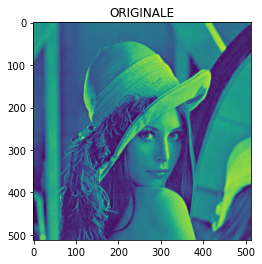

In [32]:
#%%

# voir l'image
#viewimage(im,titre='ORIGINALE')
#degrader une image
plt.title('ORIGINALE')
plt.imshow(im)

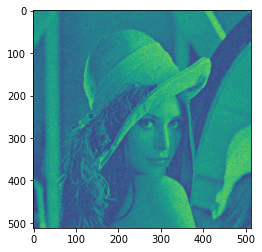

In [30]:
imb=degrade_image(im,5)

# voir l'image bruitée 
#viewimage(imb,titre='BRUITEE')

plt.title('BRUITEE')
plt.imshow(imb)

<ipython-input-22-a16b50fd0c83>:94: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numer=np.vectorize(np.complex)(np.zeros((sy,sx)))
<ipython-input-22-a16b50fd0c83>:95: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  denom=np.vectorize(np.complex)(np.zeros((sy,sx)))


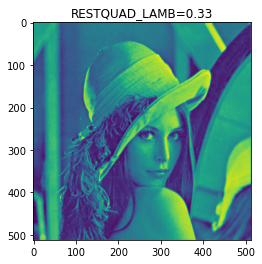

In [46]:
#%% restauration quadratique : exemple
lamb=0.33
restau=minimisation_quadratique(imb,lamb)

#viewimage(restau,title='RESTQUAD_LAMB='+str(lamb))

plt.title('RESTQUAD_LAMB='+str(lamb))
plt.imshow(restau)



In [48]:
imb=degrade_image(im,5)

but=norm2(imb-im)
lmin=0.01
lmax=30
resmin=minimisation_quadratique(imb,lmin)
resmax=minimisation_quadratique(imb,lmax)
errmin=norm2(imb-resmin)
errmax=norm2(imb-resmax)
for k in range(20): # on fait dix dichotomies
    lmil=(lmin+lmax)/2
    resmil=minimisation_quadratique(imb,lmil)
    errmil=norm2(resmil-imb)
    if errmil>but:
        lmax=lmil
        errmax=errmil
        resmax=resmil
    else:
        lmin=lmil
        errmin=errmil
        resmin=resmil
print(lmin, lmil, lmax)

<ipython-input-22-a16b50fd0c83>:94: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numer=np.vectorize(np.complex)(np.zeros((sy,sx)))
<ipython-input-22-a16b50fd0c83>:95: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  denom=np.vectorize(np.complex)(np.zeros((sy,sx)))


0.3314145851135254 0.3314431858062744 0.3314431858062744


In [67]:
l = 0.5
epsilon = 1e-5
a = 0.001
for i in range (100):
    gradient = (norm2(minimisation_quadratique(imb,(l + epsilon))-im) - norm2(minimisation_quadratique(imb,l)-im)) / epsilon
    print(gradient)
    l = max(0,l - a * gradient)
print(l)

<ipython-input-22-a16b50fd0c83>:94: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numer=np.vectorize(np.complex)(np.zeros((sy,sx)))
<ipython-input-22-a16b50fd0c83>:95: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  denom=np.vectorize(np.complex)(np.zeros((sy,sx)))


2192.6659159817063
-10263.715890687308
207.67556725331812
211.3305185048375
215.19747078855286
219.2979380197357
223.65662516676818
228.30206553408058
233.26741711571228
238.5914734077232
244.31995634586198
250.50719114005912
257.2183033407782
264.5321420459368
272.54522865405306
281.37718536527245
291.1783477429708
302.1406721927633
314.5137698993494
328.6291581389378
344.9382111284649
364.07393627087
386.9564358865318
414.98366608720966
450.4023317167593
497.0991978552774
562.5129142572405
663.144077952893
845.4432169855862
1316.4419937311322
-10263.715890687308
207.67556725331812
211.3305185048375
215.19747078855286
219.2979380197357
223.65662516676818
228.30206553408058
233.26741711571228
238.5914734077232
244.31995634586198
250.50719114005912
257.2183033407782
264.5321420459368
272.54522865405306
281.37718536527245
291.1783477429708
302.1406721927633
314.5137698993494
328.6291581389378
344.9382111284649
364.07393627087
386.9564358865318
414.98366608720966
450.4023317167593
497.099

In [34]:
#%% COMPARAISON des methodes
# vous pouvez vous inspirer de ce qui suit pour trouver les meilleurs 
# parametres de regularisation 

errq=[]
errvt=[]
erreur=[]
vk=np.arange(0,0.25,0.01);
for k in vk: 
    print (k)
    #restq=minimisation_quadratique(imb,10^(k));
    #errq.append[]=norm2(restq-myim);
    #restva=vartotale_Chambolle(imb,10**(k));
    restq=minimisation_quadratique(imb,10**(k))
    erreur.append(norm2(im-restq))
    #errvt.append(norm2(restva-myim));
    


#plt.plot(10**vk,errvt);




0.0
0.01


<ipython-input-22-a16b50fd0c83>:94: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numer=np.vectorize(np.complex)(np.zeros((sy,sx)))
<ipython-input-22-a16b50fd0c83>:95: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  denom=np.vectorize(np.complex)(np.zeros((sy,sx)))


0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24


In [35]:
#%%
u1,en1=minimise_TV_gradient(imb, 40, 1, 20)
u05,en05=minimise_TV_gradient(imb, 40, 0.5, 20)
u01,en01=minimise_TV_gradient(imb, 40, 0.1, 20)
#u05inf,en05inf=minimise_TV_gradient(imb, 10, 0.5, 200)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


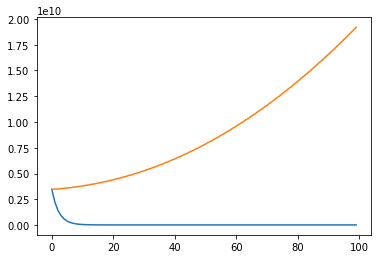

In [36]:
#%%
myim=imread('lena.tif')
imb=degrade_image(myim,25)
(u,energ)=minimise_TV_gradient(imb,1,0.1,100)   # pas = 0.1
(u,energ2)=minimise_TV_gradient(imb,1,1,100)       # pas = 1
plt.plot(energ)
plt.plot(energ2)


# 1 Débruitage par régularisation quadratique

## 1.1

L'outil resoud_quad_fourier trouve une image im qui minimise $\sum_{i} || K_{i} * im - V_i||^2$ ou les $K_{i}$ et les $V_{i}$ sont des filtres et des images respectivement.


Le gradient de la fonction f1 par rapport à w0 et w peut être calculé de la manière suivante :

$$\begin{aligned} \frac{\partial f1}{\partial w_0} &= \frac{1}{n} \sum_{i=1}^{n} -\frac{y_i}{1+\exp(y_i(x_i^Tw+w_0))} \ \frac{\partial f1}{\partial w} &= \frac{1}{n} \sum_{i=1}^{n} -\frac{y_ix_i}{1+\exp(y_i(x_i^Tw+w_0))} + \rho w \end{aligned}$$

Voici le code LaTeX pour afficher ces deux gradients :

$$\begin{aligned} \frac{\partial f1}{\partial w_0} &= \frac{1}{n} \sum_{i=1}^{n} -\frac{y_i}{1+\exp(y_i(x_i^Tw+w_0))} \ \frac{\partial f1}{\partial w} &= \frac{1}{n} \sum_{i=1}^{n} -\frac{y_ix_i}{1+\exp(y_i(x_i^Tw+w_0))} + \rho w \end{aligned}$$

Dans cette formule, n est le nombre d'exemples d'entraînement, yi est la classe cible pour l'exemple i (yi peut être 1 ou -1), xi est le vecteur de features de l'exemple i, w0 est le biais, w est le vecteur de poids, et ρ est un paramètre de régularisation.

Il est possible de prouver que la fonction f1 n'est pas convexe en utilisant son gradient. Pour qu'une fonction soit convexe, il faut que son gradient soit monotone croissant. Or, le gradient de la fonction f1 par rapport à w0 et w peut être calculé de la manière suivante :

$$\begin{aligned} \frac{\partial f1}{\partial w_0} &= \frac{1}{n} \sum_{i=1}^{n} -\frac{y_i}{1+\exp(y_i(x_i^Tw+w_0))} \ \frac{\partial f1}{\partial w} &= \frac{1}{n} \sum_{i=1}^{n} -\frac{y_ix_i}{1+\exp(y_i(x_i^Tw+w_0))} + \rho w \end{aligned}$$

On peut voir que le gradient de la fonction f1 par rapport à w0 et w n'est pas monotone croissant, car il est influencé par la fonction  (-yi/(1+exp(yi(xi^Tw+w0)))) n'est pas monotone croissante. Par conséquent, la fonction f1 n'est pas convexe.

La fonction f a pour expression :

$$f(x) = \frac{1}{1+\exp(-x)}$$

Cette fonction est croissante sur les valeurs de x positives, et décroissante sur les valeurs de x négatives. Elle atteint sa valeur maximale (égale à 1) pour x = +∞ et sa valeur minimale (égale à 0) pour x = -∞.

Par conséquent, la fonction logistique n'est pas monotone croissante, et par extension, le gradient de la fonction f1 par rapport à w0 et w, qui est influencé par la fonction logistique, n'est pas monotone croissant non plus.

La matrice Hessienne de la fonction f1 par rapport à w0 et w peut être calculée de la manière suivante :

$$\begin{bmatrix} \frac{\partial^2 f1}{\partial w_0^2} & \frac{\partial^2 f1}{\partial w_0 \partial w} \ \frac{\partial^2 f1}{\partial w \partial w_0} & \frac{\partial^2 f1}{\partial w^2} \end{bmatrix} = \frac{1}{n} \sum_{i=1}^{n} \frac{y_i^2 \exp(y_i(x_i^Tw+w_0))}{(1+\exp(y_i(x_i^Tw+w_0)))^2} \begin{bmatrix} 1 & x_i^T \ x_i & x_i x_i^T \end{bmatrix} + \rho \begin{bmatrix} 0 & 0 \ 0 & I \end{bmatrix}$$

Voici le code LaTeX pour afficher cette matrice :

$$\begin{bmatrix} \frac{\partial^2 f1}{\partial w_0^2} & \frac{\partial^2 f1}{

Pour que la fonction f1 soit convexe, il faudrait que son gradient (c'est-à-dire sa pente) soit toujours croissant. Or, le gradient de la fonction f1 par rapport à w0 et w peut être calculé de la manière suivante :

$$\begin{aligned} \frac{\partial f1}{\partial w_0} &= \frac{1}{n} \sum_{i=1}^{n} -\frac{y_i}{1+\exp(y_i(x_i^Tw+w_0))} \ \frac{\partial f1}{\partial w} &= \frac{1}{n} \sum_{i=1}^{n} -\frac{y_ix_i}{1+\exp(y_i(x_i^Tw+w_0))} + \rho w \end{aligned}$$

On peut voir que le gradient de la fonction f1 par rapport à w0 et w n'est pas toujours croissant, car il est influencé par la fonction logistique (-yi/(1+exp(yi(xi^Tw+w0)))), qui elle-même n'est pas croissante. Donc, la fonction f1 n'est pas convexe.

En d'autres termes, la fonction f1 a des parties de sa courbe qui sont en dents de scie et qui "descendent" au lieu de "monter", ce qui signifie qu'elle n'est pas convexe.